## Heart Signal Classification using STFT

In [28]:
import keras
import pathlib
import soundfile
import librosa.display
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

**Load the data** from the data directory. We are using `soundfile` to read the audio files and get the labels from the directory structure.

In [3]:
DATASET_PATH = "data"

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
    # from google.colab import drive
    print("Data not found")

In [4]:
def load_data(data_dir):
    data = []
    labels = []
    sample_rate = []
    # Iterate over all the files of the directory it has two subdirectories with the labels
    for _, dir in enumerate(data_dir.iterdir()):
        for file in dir.iterdir():
            audio, sr = soundfile.read(file)
            sample_rate.append(sr)
            data.append(audio)
            labels.append(str(dir).split("/")[-1])

    return data, np.array(sample_rate), np.array(labels)

data, sample_rate, labels = load_data(data_dir)
sample_rate = 4000
print("Sample rate: ", sample_rate)

Sample rate:  4000


### Showcase some of the audio files

The below code will showcase some of the audio files from the dataset in the form of a plot of the audio signal.

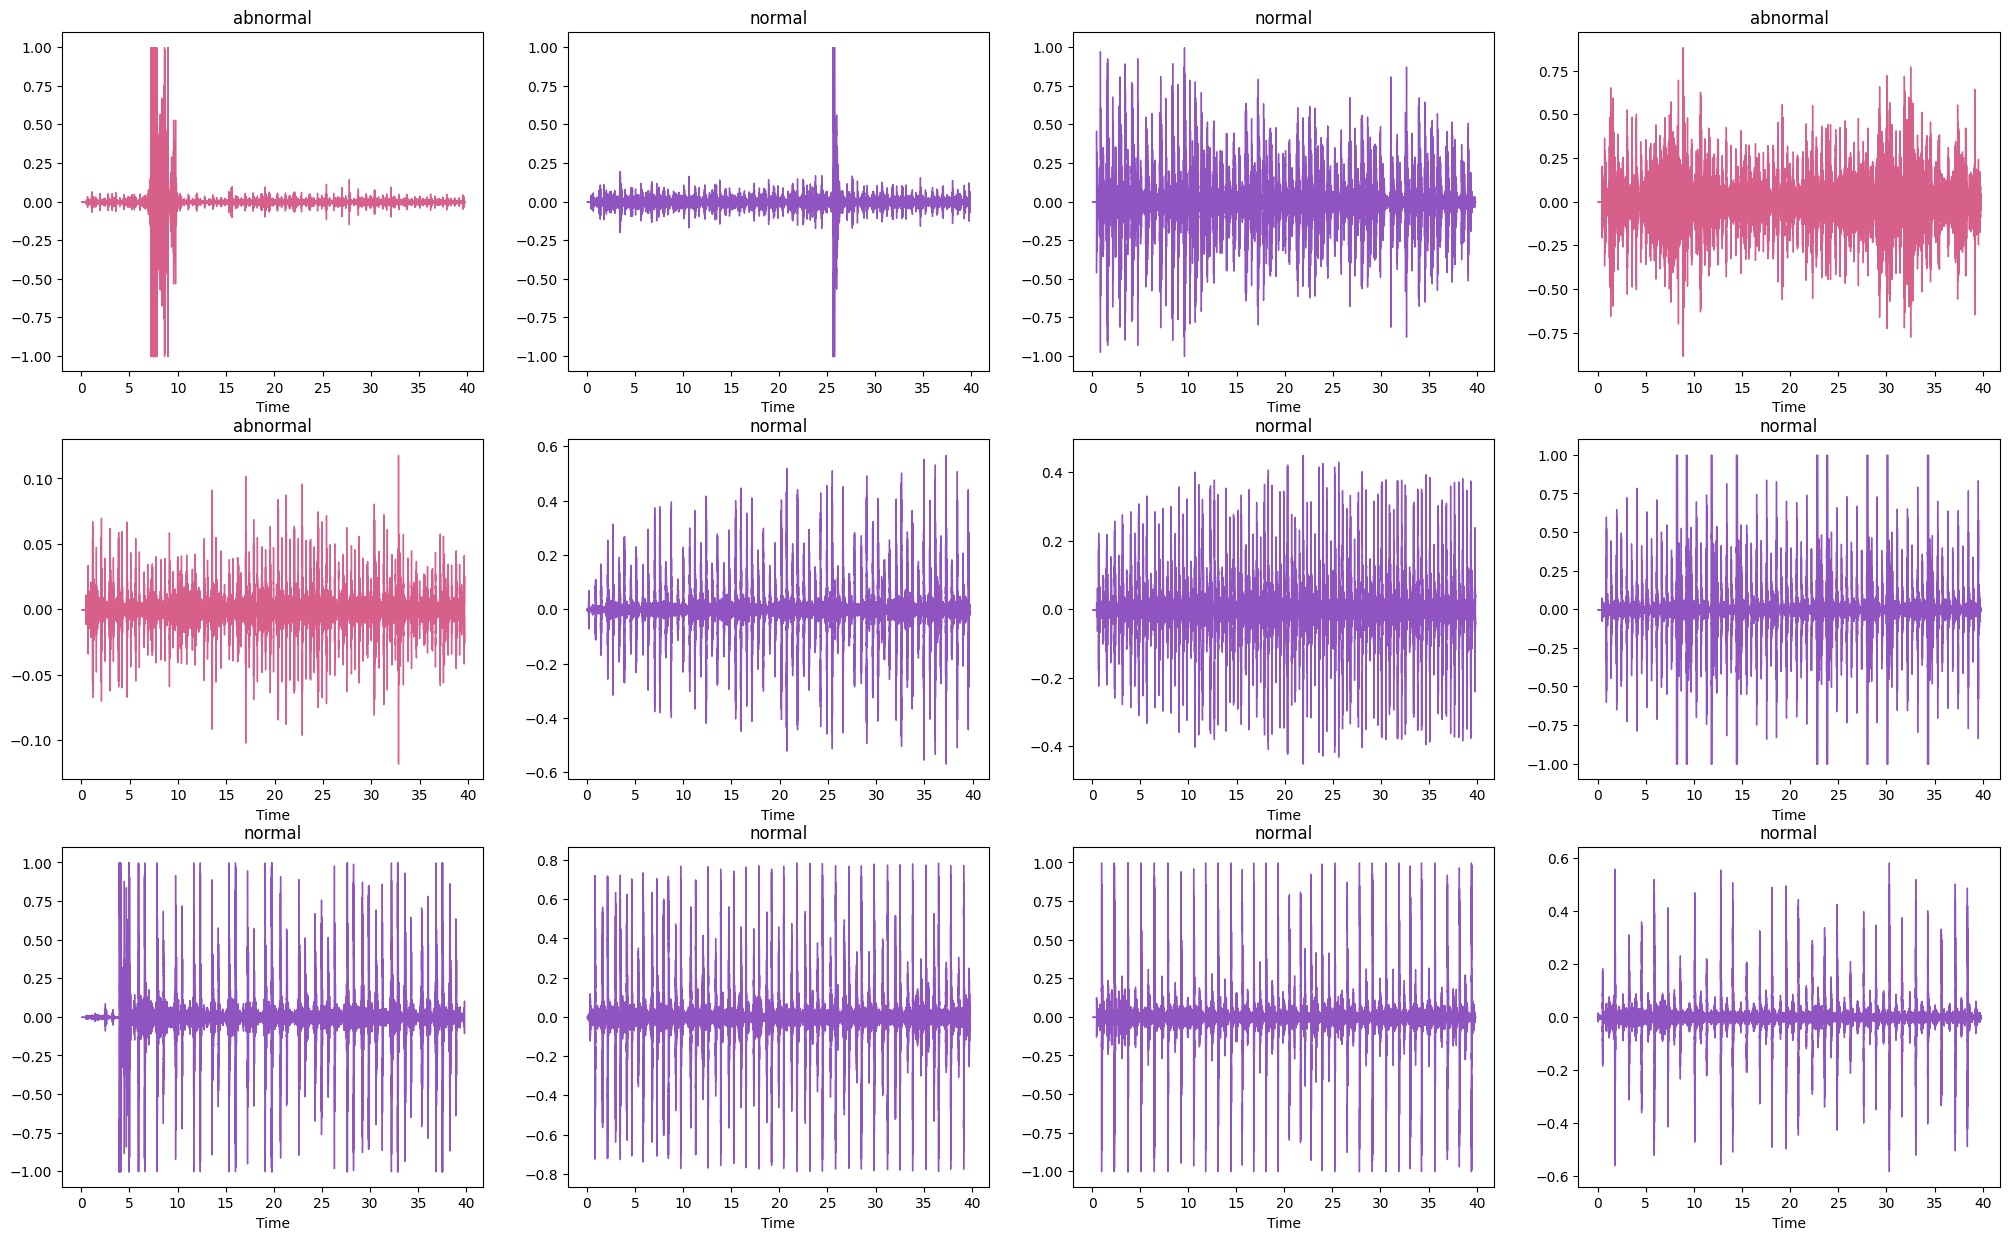

In [5]:
fig, axes = plt.subplots(3, 4, figsize=(25, 15))
for i in range(12):
    ax = axes[i // 4, i % 4]
    # create a random index
    idx = np.random.randint(len(data))
    color = '#8f54bf' if labels[idx] == 'normal' else '#d6608a'
    plt.subplot(3, 4, i+1)
    librosa.display.waveshow(data[idx], sr=sample_rate, ax=ax, color=color)
    ax.set_title(labels[idx])
plt.show()

### Compare Features of abnormal and normal heart signals

Now we will see the difference between the features of normal and abnormal heart signals. Below is a showcase on a small scale of what will be done on a larger scale.

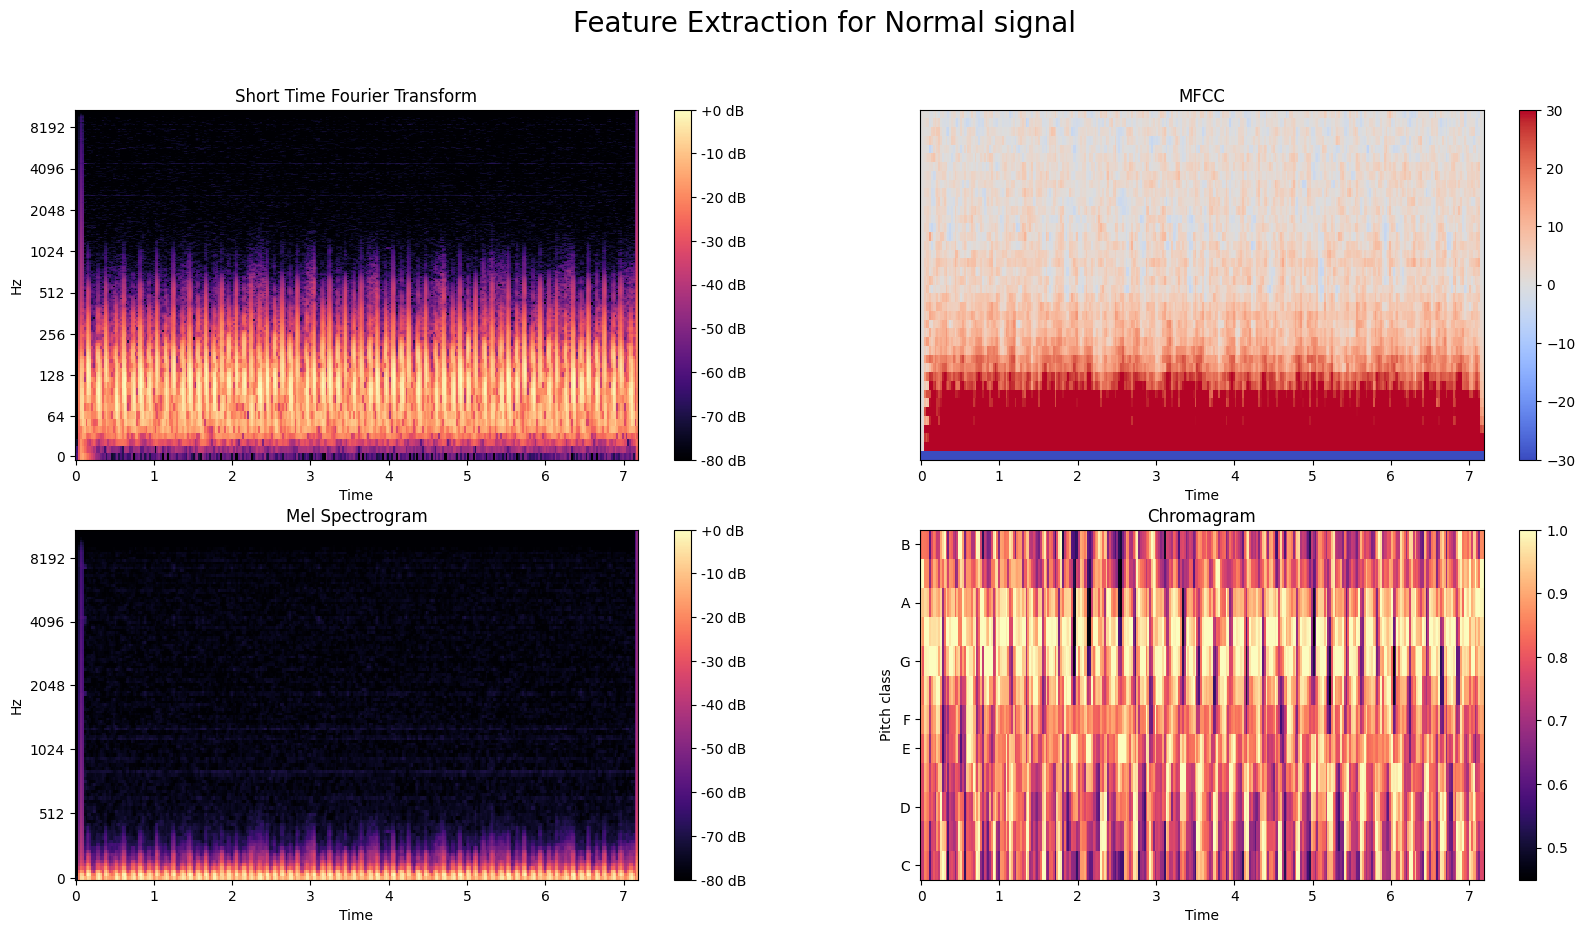

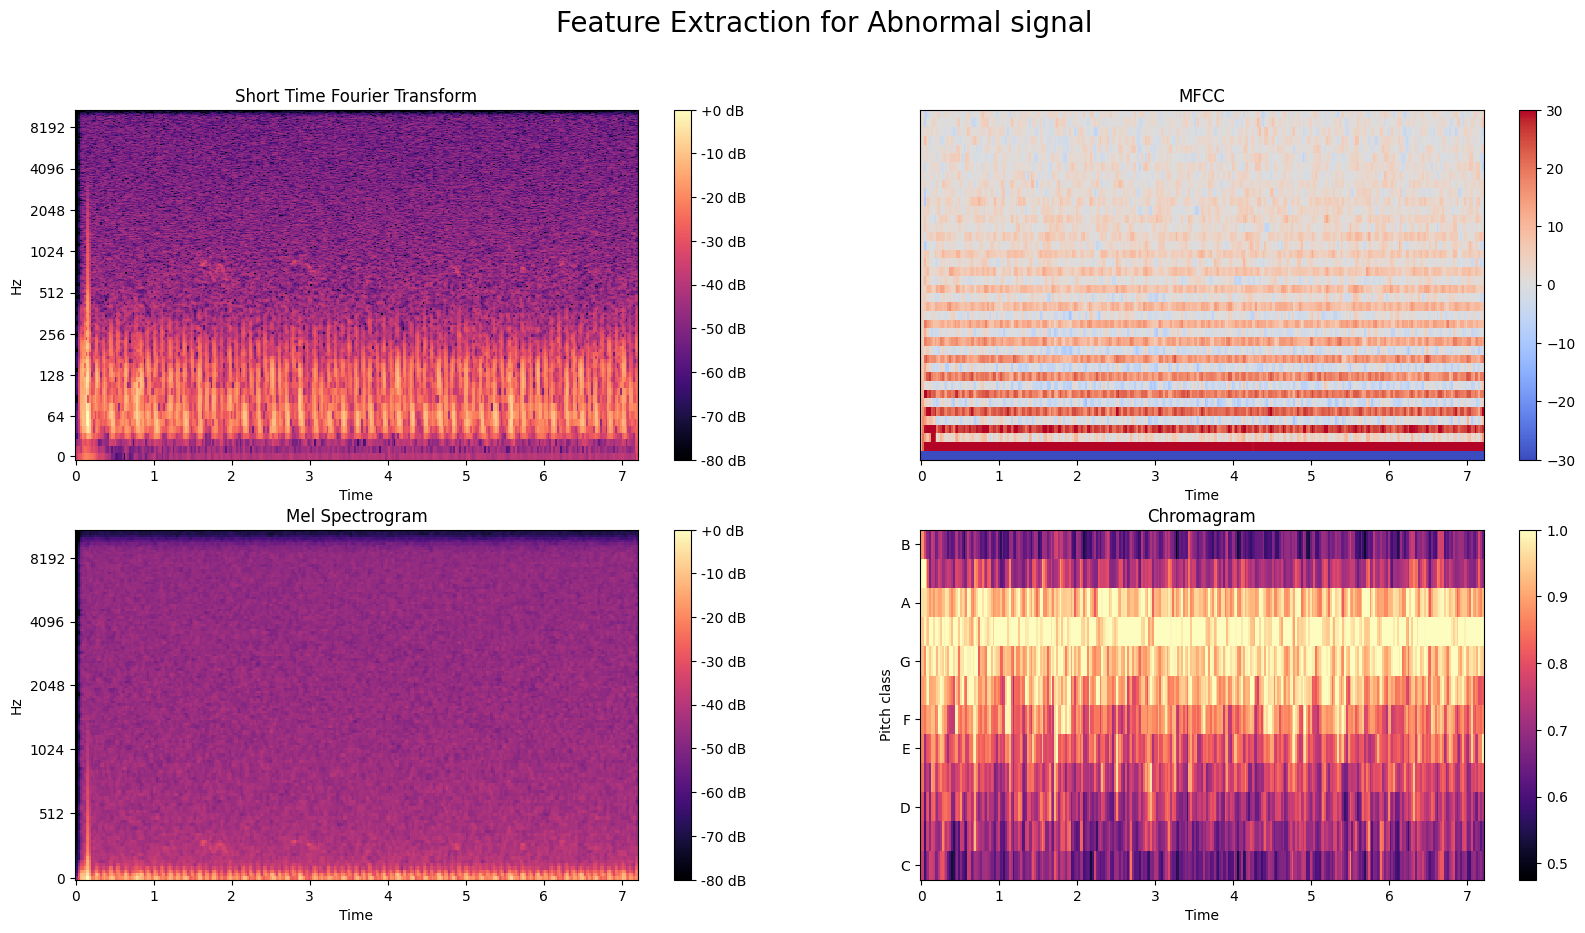

In [6]:
from matplotlib.colors import Normalize

def plot_features(signal, label: str):
    # Plot STFT, MFCC, Mel Spectrogram and Chromagram for the heartbeat
    audio = data[np.random.choice(np.where(labels == label)[0])]
    fig, _ = plt.subplots(2, 2, figsize=(20, 10))
    fig.suptitle(f'Feature Extraction for {label.capitalize()} signal', fontsize=20)

    # STFT for normal heartbeat
    plt.subplot(2, 2, 1)
    stft = np.abs(librosa.stft(audio))
    librosa.display.specshow(librosa.amplitude_to_db(stft, ref=np.max), y_axis='log', x_axis='time')
    plt.title('Short Time Fourier Transform')
    plt.colorbar(format='%+2.0f dB')

    # MFCC for normal heartbeat ( Uses STFT and Mel Spectrogram and Discrete Cosine Transform )
    plt.subplot(2, 2, 2)
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    librosa.display.specshow(mfccs, x_axis='time', norm=Normalize(vmin=-30,vmax=30))
    plt.colorbar()
    plt.title('MFCC')

    # Mel Spectrogram for normal heartbeat ( Uses STFT )
    plt.subplot(2, 2, 3)
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sample_rate)
    librosa.display.specshow(librosa.power_to_db(mel_spectrogram, ref=np.max), y_axis='mel', x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel Spectrogram')

    # Chromagram for normal heartbeat ( Uses STFT and classifies to 12 pitch classes)
    plt.subplot(2, 2, 4)
    chromagram = librosa.feature.chroma_stft(S=stft, sr=sample_rate)
    librosa.display.specshow(chromagram, y_axis='chroma', x_axis='time')
    plt.colorbar()
    plt.title('Chromagram')

    plt.show()

plot_features(data, 'normal')
plot_features(data, 'abnormal')

### Extract Features using STFT, MFCC, and Chromagram

In [7]:
# Extracting Features using Short Time Fourier Transform, MFCC, Mel Spectrogram and Chromagram
def extract_features(data, print_string="Extracting Features"):
    stft_features = []
    mfcc_features = []
    mel_spectrogram_features = []
    chromagram_features = []

    for audio in data:
        stft = np.abs(librosa.stft(audio))
        stft_features.append(np.mean(stft))
        mfccs = np.mean(librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40).T, axis=0)
        mfcc_features.append(mfccs)
        mel_spectrogram = np.mean(librosa.feature.melspectrogram(y=audio, sr=sample_rate).T, axis=0)
        mel_spectrogram_features.append(mel_spectrogram)
        chromagram = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
        chromagram_features.append(chromagram)

    print(f'{print_string} Done: STFT: {stft_features[0].shape}, MFCC: {mfcc_features[0].shape}, Mel Spectrogram: {mel_spectrogram_features[0].shape}, Chromagram: {chromagram_features[0].shape}')
    return np.hstack((np.array(stft_features).reshape(-1, 1),  np.array(mfcc_features), np.array(mel_spectrogram_features), np.array(chromagram_features)))

features = extract_features(data)

/home/shurtu-gal/Stuff/Course/env/lib/python3.11/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Extracting Features Done: STFT: (), MFCC: (40,), Mel Spectrogram: (128,), Chromagram: (12,)


We are getting 128 features from Mel spectrogram, 12 features from Chromagram, 40 features from MFCC and 1 feature from STFT.

In [8]:
print(f'\nAudio samples represented: {features.shape[0]}')
print(f'Number of features per sample: {features[0].shape[0]}')

features_df = pd.DataFrame(features)
# put labels in the dataframe
features_df['labels'] = labels
features_df



Audio samples represented: 941
Number of features per sample: 181


,0,1,2,3,4,5,6,7,8,9,...,172,173,174,175,176,177,178,179,180,labels
0,0.984162,-352.316083,87.891269,65.824505,52.871344,44.504030,38.257027,32.564092,27.863640,23.391845,...,0.762572,0.780712,0.823883,0.846185,0.841691,0.846938,0.815215,0.790422,0.781063,abnormal
1,0.025973,-652.994515,108.167968,67.595389,63.132097,44.758991,35.915241,24.224912,17.008412,10.060838,...,0.803821,0.879658,0.905256,0.868424,0.807656,0.728424,0.688504,0.675248,0.674464,abnormal
2,0.308796,-495.727744,74.476252,68.928240,62.992253,55.510956,47.815551,39.894426,32.642771,26.008656,...,0.770308,0.733502,0.761993,0.815628,0.823867,0.853982,0.870240,0.861462,0.860701,abnormal
3,0.051725,-513.081745,101.411279,56.550149,57.705722,20.952562,30.349968,4.216872,18.230339,-0.205451,...,0.771490,0.762414,0.804276,0.856245,0.888335,0.933339,0.918853,0.853396,0.802025,abnormal
4,0.123248,-468.901692,141.900263,47.451922,41.398345,22.481400,17.570113,9.941195,6.461886,2.288923,...,0.781649,0.777775,0.779543,0.777518,0.756892,0.768115,0.783949,0.798223,0.786117,abnormal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
936,1.856758,-263.877835,116.479096,56.411335,41.168278,30.277775,26.127235,20.116933,17.404369,13.540649,...,0.828341,0.819378,0.833795,0.856751,0.836258,0.833685,0.842073,0.832016,0.807352,normal
937,0.028689,-512.647241,49.322455,15.918474,36.912255,11.259138,32.401882,8.729371,28.004079,7.107054,...,0.813176,0.838001,0.881443,0.901841,0.918754,0.967280,0.956507,0.811901,0.714400,normal
938,0.223891,-473.574467,76.934409,68.363346,57.962716,47.136466,37.655907,30.374199,24.821761,20.319405,...,0.800632,0.791758,0.793700,0.844008,0.872177,0.848473,0.839047,0.833501,0.831300,normal
939,0.107909,-524.656123,90.158450,64.168865,53.952564,41.358466,33.145326,26.630655,24.632450,17.093982,...,0.741353,0.700564,0.691191,0.703370,0.747767,0.744050,0.746943,0.734374,0.730613,normal


### Preprocesssing

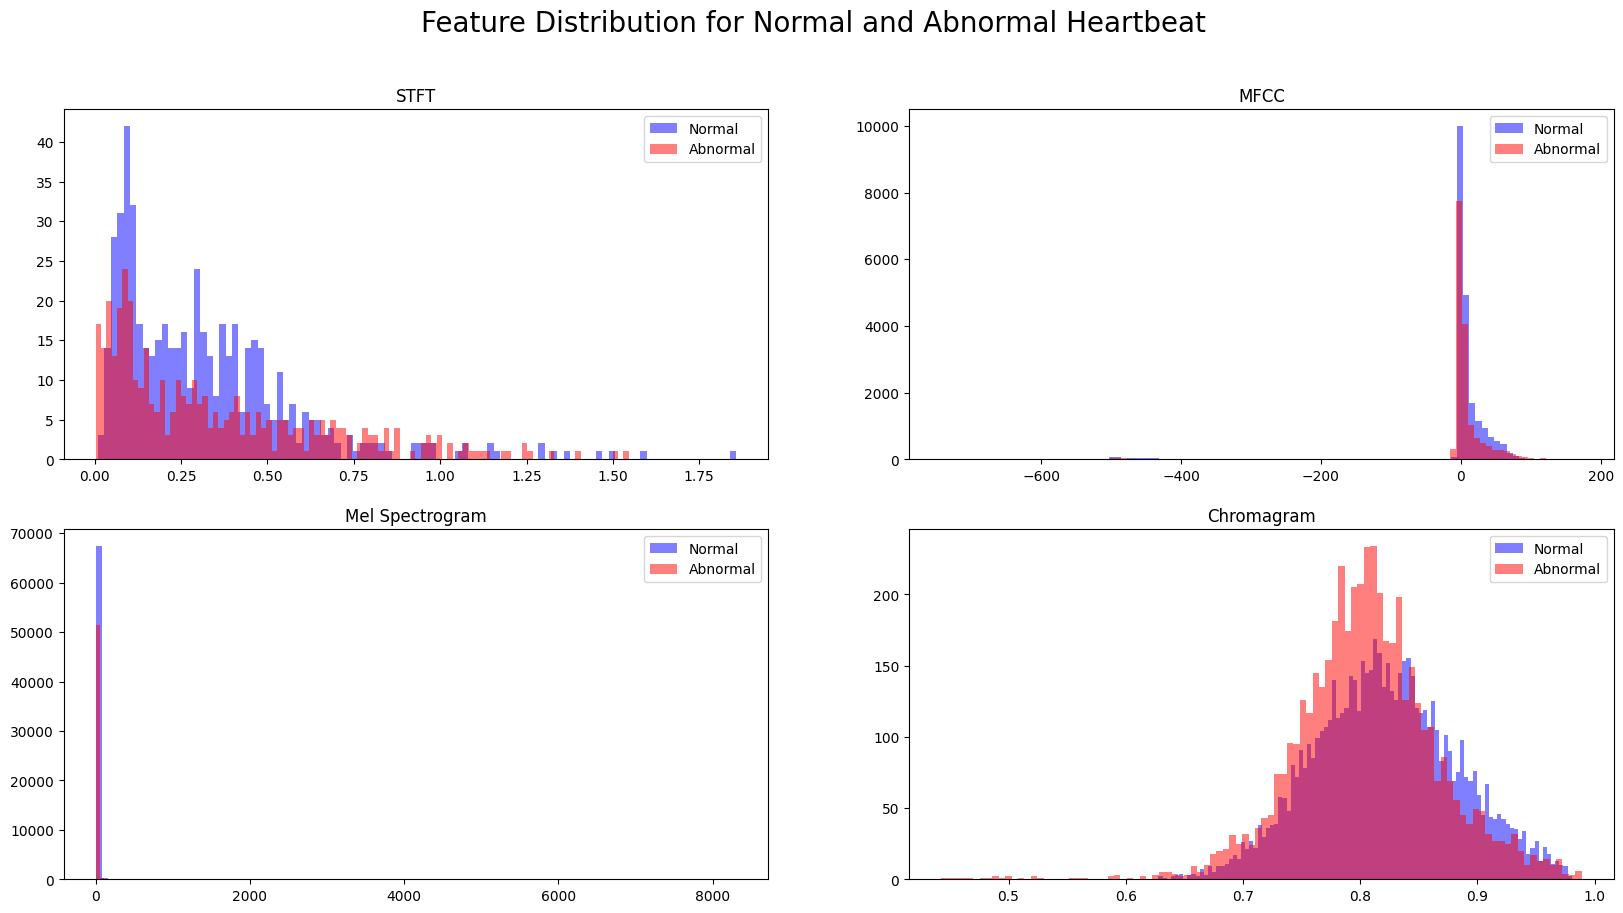

In [9]:
# Check feature distribution for each label
normal_features = np.array(features_df[features_df['labels'] == 'normal'].drop('labels', axis=1))
abnormal_features = np.array(features_df[features_df['labels'] == 'abnormal'].drop('labels', axis=1))

fig, axes = plt.subplots(2, 2, figsize=(20, 10))
fig.suptitle('Feature Distribution for Normal and Abnormal Heartbeat', fontsize=20)

def plot_distribution(normal_data, abnormal_data, feature_name, pos):
    plt.subplot(2, 2, pos)
    plt.title(feature_name)
    plt.hist(normal_data, bins=100, alpha=0.5, color='b', label='Normal')
    plt.hist(abnormal_data, bins=100, alpha=0.5, color='r', label='Abnormal')
    plt.legend()
    

plot_distribution(normal_features[:, 0], abnormal_features[:, 0], 'STFT', 1)
plot_distribution(normal_features[:, 1:41].flatten(), abnormal_features[:, 1:41].flatten(), 'MFCC', 2)
plot_distribution(normal_features[:, 41:169].flatten(), abnormal_features[:, 41:169].flatten(), 'Mel Spectrogram', 3)
plot_distribution(normal_features[:, 169:].flatten(), abnormal_features[:, 169:].flatten(), 'Chromagram', 4)

plt.show()

In [10]:
# Get parameters for the STFT, MFCC, Mel Spectrogram and Chromagram features (mean, std, min, max)
def print_params(features_df):
    features_df_stft = features_df.loc[:, :0]
    features_df_mfcc = features_df.loc[:, 1:40]
    features_df_mel_spectrogram = features_df.loc[:, 41:168]
    features_df_chromagram = features_df.loc[:, 169:180]

    print(f'STFT Features: mean: {features_df_stft.stack().mean()},  std: {features_df_stft.stack().std()}, min: {features_df_stft.min().min()}, max: {features_df_stft.max().max()}')
    print(f'MFCC Features: mean: {features_df_mfcc.stack().mean()}, std: {features_df_mfcc.stack().std()}, min: {features_df_mfcc.min().min()}, max: {features_df_mfcc.max().max()}')
    print(f'Mel Spectrogram Features: mean: {features_df_mel_spectrogram.stack().mean()}, std: {features_df_mel_spectrogram.stack().std()}, min: {features_df_mel_spectrogram.min().min()}, max: {features_df_mel_spectrogram.max().max()}')
    print(f'Chromagram Features: mean: {features_df_chromagram.stack().mean()}, std: {features_df_chromagram.stack().std()}, min: {features_df_chromagram.min().min()}, max: {features_df_chromagram.max().max()}')

Scale the features using `StandardScaler` and `MinMaxScaler` for better performance.

In [11]:
# Feature Scaling and Normalization
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

print('Parameters before scaling and normalization:')
print_params(features_df)

scaler = StandardScaler()
features_scaled = features.copy()
features_scaled[:, :1] = scaler.fit_transform(features[:, :1])

scaler = MinMaxScaler()
features_minmax = features.copy()
features_minmax[:, :1] = scaler.fit_transform(features[:, :1])

print('\nParameters after scaling and normalization:')
print_params(pd.DataFrame(features_scaled))

print('\nParameters after MinMax scaling:')
print_params(pd.DataFrame(features_minmax))

Parameters before scaling and normalization:
STFT Features: mean: 0.3320191894084279,  std: 0.2887611831964933, min: 0.0025506824156082343, max: 1.8567575058160326
MFCC Features: mean: -0.8170613065800402, std: 77.12842715496195, min: -743.2326126010717, max: 172.68842933805306
Mel Spectrogram Features: mean: 6.783504110978435, std: 93.43172917461894, min: 3.232929060754023e-08, max: 8305.237506372572
Chromagram Features: mean: 0.8142450129227182, std: 0.06131104772830024, min: 0.44248420547362244, max: 0.9888030561278763

Parameters after scaling and normalization:
STFT Features: mean: -7.550932367269927e-18,  std: 1.0005317735020884, min: -1.141579023764764, max: 5.2830824245646575
MFCC Features: mean: -0.8170613065800402, std: 77.12842715496195, min: -743.2326126010717, max: 172.68842933805306
Mel Spectrogram Features: mean: 6.783504110978435, std: 93.43172917461894, min: 3.232929060754023e-08, max: 8305.237506372572
Chromagram Features: mean: 0.8142450129227182, std: 0.061311047728

In [12]:
# Train and Test Split [8, 2]
from sklearn.model_selection import train_test_split

X_train, X_test, y_train_normal, y_test_normal = train_test_split(features_scaled, labels, test_size=0.2, random_state=42)

print(f'X_train: {X_train.shape}, y_train: {len(y_train_normal)}')
print(f'X_test: {X_test.shape}, y_test: {len(y_test_normal)}')

y_train_normal = np.array([1 if label == 'normal' else 0 for label in y_train_normal])
y_test_normal = np.array([1 if label == 'normal' else 0 for label in y_test_normal])

X_train: (752, 181), y_train: 752
X_test: (189, 181), y_test: 189


### Compare different classifiers

We will compare different classifiers and show the accuracy of each classifier.

In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

classification_models = [
    KNeighborsClassifier(),#(3),
    SVC(kernel='linear'),#, C=0.025),
    SVC(kernel='rbf'),
    DecisionTreeClassifier(),#max_depth=5),
    RandomForestClassifier(),#max_depth=5, n_estimators=10, max_features=1),
    AdaBoostClassifier(algorithm='SAMME'),#n_estimators=50),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

scores = []
for model in classification_models:
    model.fit(X_train, y_train_normal)
    score = model.score(X_test, y_test_normal)
    model_name = type(model).__name__
    if model_name=='SVC' and model.kernel=='rbf': model_name+=' RBF kernel'
    scores.append((model_name,(f'{100*score:.2f}%')))

scores_df = pd.DataFrame(scores,columns=['Classifier','Accuracy Score'])
scores_df.sort_values(by='Accuracy Score',axis=0,ascending=False)

/home/shurtu-gal/Stuff/Course/env/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


,Classifier,Accuracy Score
4,RandomForestClassifier,87.83%
1,SVC,84.13%
5,AdaBoostClassifier,81.48%
3,DecisionTreeClassifier,76.72%
0,KNeighborsClassifier,75.13%
2,SVC RBF kernel,65.61%
7,QuadraticDiscriminantAnalysis,48.15%
6,GaussianNB,40.74%


**Grid Search** is used to find the best hyperparameters for the classifiers.

In [14]:
from sklearn.model_selection import GridSearchCV

def grid_search(model, param_grid):
    # Perform grid search
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train_normal)

    # Get the best parameters and the corresponding accuracy
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    print("Best Parameters:", best_params)
    print("Best Cross-Validation Accuracy:", best_score)

    # Evaluate the model on the test set using the best parameters
    best_model = grid_search.best_estimator_
    test_score = best_model.score(X_test, y_test_normal)
    print(f'Test Set Accuracy for {type(model).__name__}: {100*test_score:.2f}%')

    return best_model


In [15]:
# Plot learning curve for the model
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

#### Grid Search for AdaBoostClassifier

In [16]:
param_grid_ada = {
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.1, 0.5, 1],
    'algorithm': ['SAMME'],
    'random_state': [42],
}


best_model_ada = grid_search(AdaBoostClassifier(), param_grid_ada)

Best Parameters: {'algorithm': 'SAMME', 'learning_rate': 1, 'n_estimators': 100, 'random_state': 42}
Best Cross-Validation Accuracy: 0.8418278145695364
Test Set Accuracy for AdaBoostClassifier: 84.66%


<module 'matplotlib.pyplot' from '/home/shurtu-gal/Stuff/Course/env/lib/python3.11/site-packages/matplotlib/pyplot.py'>

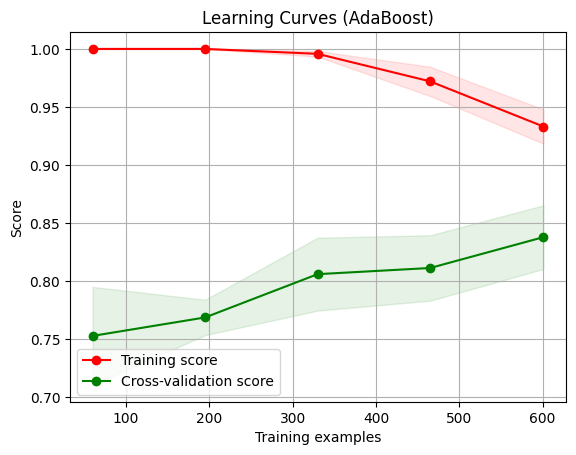

In [17]:
title = "Learning Curves (AdaBoost)"
plot_learning_curve(best_model_ada, title, X_train, y_train_normal, cv=5)

#### Tuning for RandomForestClassifier

In [29]:
best_model_rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features=None,
)
best_model_rf.fit(X_train, y_train_normal)
best_score = best_model_rf.score(X_test, y_test_normal)

print(f'Test Set Accuracy for RandomForestClassifier: {100*best_score:.2f}%')

Test Set Accuracy for RandomForestClassifier: 87.83%


<module 'matplotlib.pyplot' from '/home/shurtu-gal/Stuff/Course/env/lib/python3.11/site-packages/matplotlib/pyplot.py'>

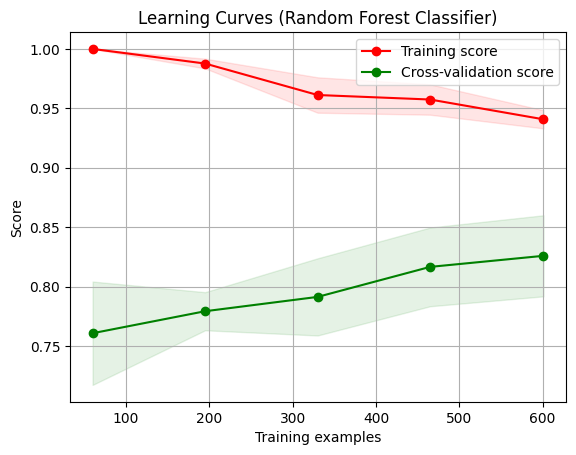

In [19]:
title = "Learning Curves (Random Forest Classifier)"
plot_learning_curve(best_model_rf, title, X_train, y_train_normal, cv=5)

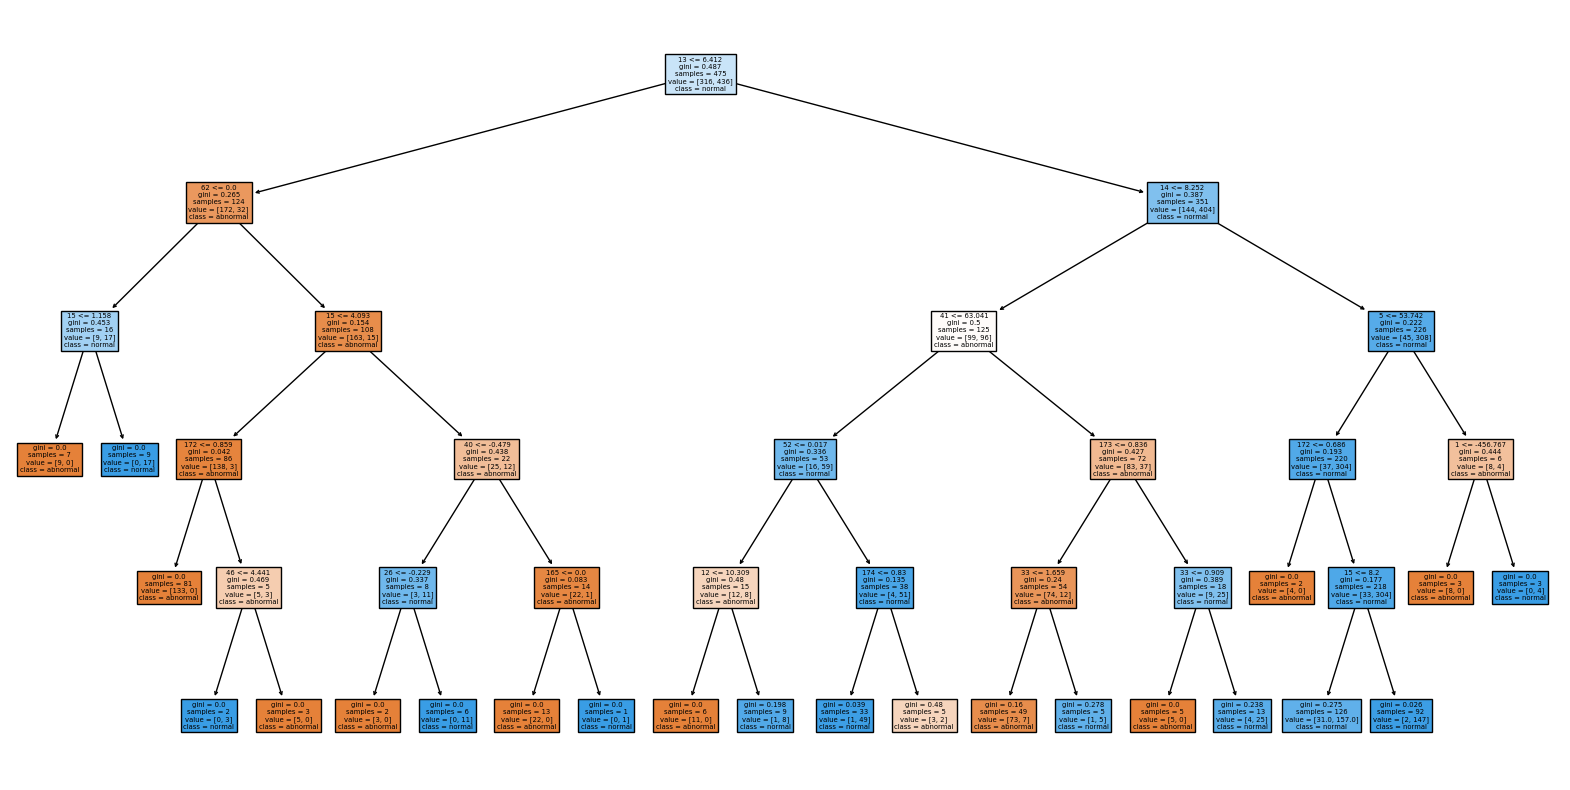

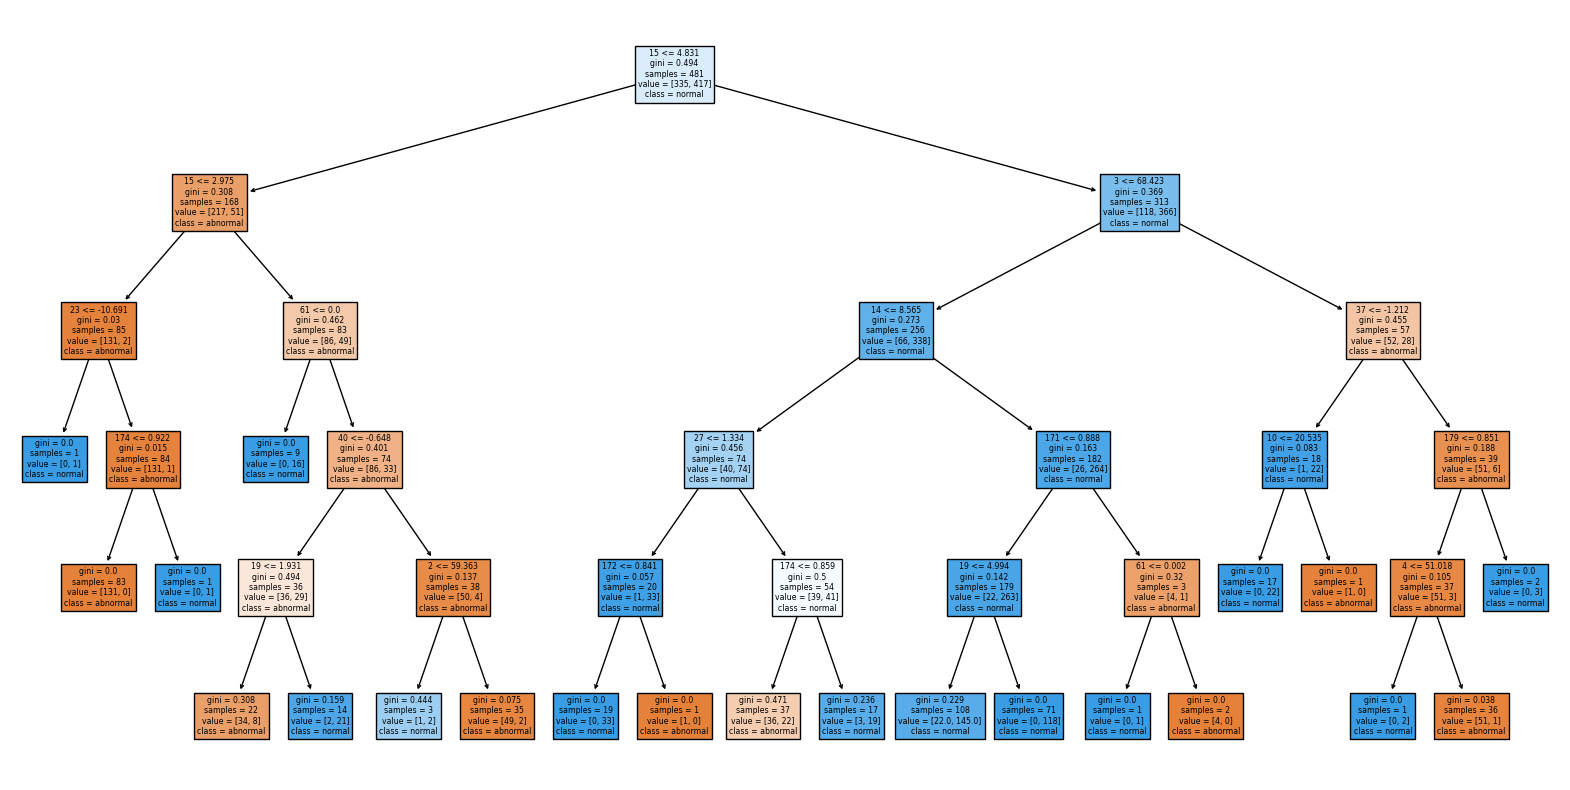

In [20]:
# Visualizing the Decision Tree
from sklearn import tree

plt.figure(figsize=(20, 10))
tree.plot_tree(best_model_rf.estimators_[0], filled=True, class_names=['abnormal', 'normal'], feature_names=features_df.columns)
plt.show()

plt.figure(figsize=(20, 10))
tree.plot_tree(best_model_rf.estimators_[1], filled=True, class_names=['abnormal', 'normal'], feature_names=features_df.columns)
plt.show()

#### Performance metrics of RandomForestClassifier

              precision    recall  f1-score   support

           0       0.88      0.82      0.85        77
           1       0.88      0.92      0.90       112

    accuracy                           0.88       189
   macro avg       0.88      0.87      0.87       189
weighted avg       0.88      0.88      0.88       189



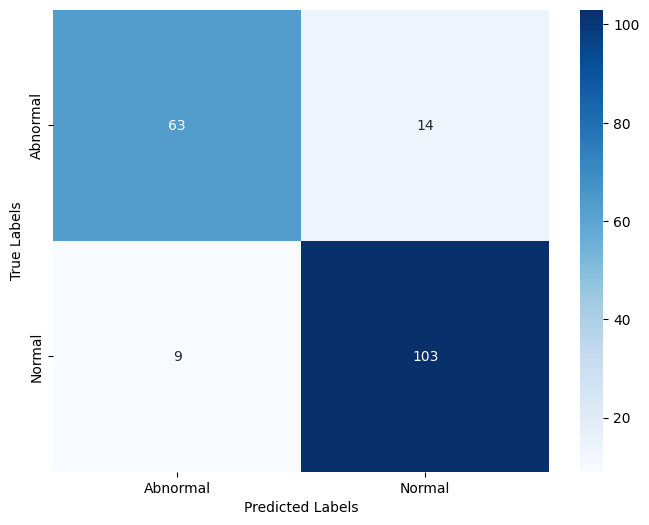

In [30]:
# Confusion Matrix for Random Forest Classifier
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_pred = best_model_rf.predict(X_test)
conf_matrix = confusion_matrix(y_test_normal, y_pred)
report = classification_report(y_test_normal, y_pred)
print(report)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Abnormal', 'Normal'], yticklabels=['Abnormal', 'Normal'])

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

plt.show()


In [22]:
# Try Convolutional Neural Network

from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, Dropout
from keras.optimizers import Adam

scores = []

for i in range(5):
    model = Sequential()
    model.add(Conv1D(32, 2, activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(MaxPooling1D())
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train_normal, epochs=10, validation_data=(X_test, y_test_normal), verbose=0)

    score = model.evaluate(X_test, y_test_normal    )
    scores.append(score)

print(f'CNN Accuracy: {100*np.mean([score[1] for score in scores]):.2f}%')


6/6 [==============================] - 0s 1ms/step - loss: 0.7636 - accuracy: 0.7619
CNN Accuracy: 76.61%


In [23]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 180, 32)           96        
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 90, 32)            0         
 g1D)                                                            
                                                                 
 flatten_4 (Flatten)         (None, 2880)              0         
                                                                 
 dense_8 (Dense)             (None, 64)                184384    
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                 65        
                                                      

In [25]:
# Hyperparameter Tuning

from keras_tuner import HyperModel, RandomSearch, Hyperband
from keras_tuner.engine.hyperparameters import HyperParameters

class CNNHyperModel(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        model = Sequential()
        model.add(Conv1D(hp.Int('units', 32, 256, 32), 2, activation='relu', input_shape=self.input_shape))
        model.add(MaxPooling1D())
        model.add(Flatten())
        model.add(Dense(hp.Int('units', 32, 256, 32), activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(1, activation='sigmoid'))

        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        return model
    
hypermodel = CNNHyperModel(input_shape=(X_train.shape[1], 1))

tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials=10,
    directory='output',
    project_name='heartbeats'
)

tuner.search(X_train, y_train_normal, epochs=10, validation_data=(X_test, y_test_normal), verbose=0)

best_model = tuner.get_best_models(num_models=1)[0]

hist = best_model.fit(X_train, y_train_normal, epochs=10, validation_data=(X_test, y_test_normal), verbose=0)

score = best_model.evaluate(X_test, y_test_normal)

print(f'CNN Hyperparameter Tuning Accuracy: {100*score[1]:.2f}%')

6/6 [==============================] - 0s 3ms/step - loss: 0.4651 - accuracy: 0.7778
CNN Hyperparameter Tuning Accuracy: 77.78%


#### Performance metrics of CNN model

6/6 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

           0       0.81      0.60      0.69        77
           1       0.77      0.90      0.83       112

    accuracy                           0.78       189
   macro avg       0.79      0.75      0.76       189
weighted avg       0.78      0.78      0.77       189



Text(50.722222222222214, 0.5, 'Actual')

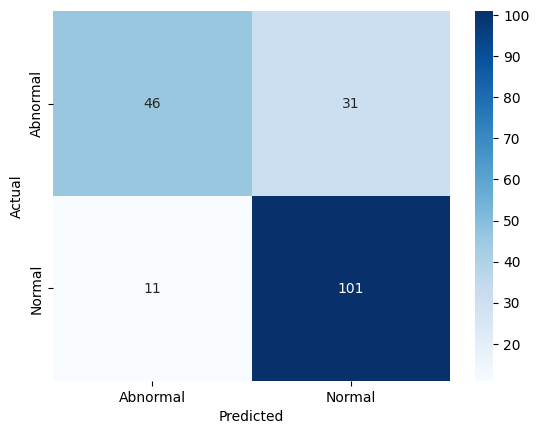

In [27]:
# Confusion Matrix
y_pred = best_model.predict(X_test)
y_pred = np.round(y_pred).flatten()

cm = confusion_matrix(y_test_normal, y_pred)
report_cnn = classification_report(y_test_normal, y_pred)
print(report_cnn)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Abnormal', 'Normal'], yticklabels=['Abnormal', 'Normal'])
plt.xlabel('Predicted')
plt.ylabel('Actual')


In [ ]:
# Save the model as a .h5 file

best_model.save('./output/model/heartbeat_classifier.h5')

/home/shurtu-gal/Stuff/Course/env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


![image.png](./images/cnn.png)

#### References

- [Google Tensorflow Blog for audio classification](https://www.tensorflow.org/tutorials/audio/simple_audio)
- [Librosa](https://librosa.org/doc/main/feature.html)
- [ZCHSound: Open-Source ZJU Paediatric Heart Sound Database With Congenital Heart Disease](https://pubmed.ncbi.nlm.nih.gov/38194403/)